In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
import numpy.polynomial
import ipywidgets as widgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plab

# Defining functions

## Basic functions

In [2]:
def closest(lst, K):
    
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def FD_dist(HWHM, center, wavelengths_to_evaluate, height = 1):
    return height*(1/(1+np.exp((center-wavelengths_to_evaluate)/HWHM)))

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance


# Importing data

## Import rainbow measuremenets

In [3]:
# In this section we will import all the rainbow measurements of
# a certain device folder and search for the red and blue sweep if they are available.

device_foldername =   'OT2' # First of all name the device folder name:  'PM6_IO-4Cl'  '091410Y61' 'ThY6'

device_foldername_list = os.listdir(os.path.join(os.getcwd(), 'RainbowMeasures'))

device_foldername_found = any(device_foldername in sub for sub in device_foldername_list)  #We check if the device_foldername is present in any of the folders inside the RainbowMeausres folder

if not device_foldername_found:  #And in case it is not present, we send a message for checking again the device_foldername input
    print('Ooops, it seems that the device ' + device_foldername + ' is not found in the RainbowMeasures folder. Check again your device_foldername input!! :)')

if device_foldername_found:  #In case we found a match between device_foldername and device_foldername list we will proceed to extract the data
    device_foldername_found = [s for s in device_foldername_list if device_foldername in s] #For that we make a list with the names of all the device_foldernames that cointains our imput name
    
    #And start checking if any of those contains '_RS' indicating a red sweep rainbow data
    device_foldername_RS = any('_RS' in sub for sub in device_foldername_found)  
    if not device_foldername_RS:    #In case there is no '_RS' folder we print a message
        print('No Red Sweep rainbow data found for '+device_foldername)

    if device_foldername_RS: #In case we find a match, we get the name of the concret folder in the device_foldername_RS variable
        device_foldername_RS = [s for s in device_foldername_found if '_RS' in s][0]
        print('Red Sweep rainbow data found: '+ device_foldername_RS)
        device_foldername_RS_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_RS,'TXT files')

        RS_cellname = list()       #We initialize a list to save all the cellnames of the red sweep
        for entry in os.scandir(device_foldername_RS_path):  #search for all the entries inside the device_foldername_RS/TXT Files path
            if entry.is_dir(follow_symlinks=False):        #In case the entry is a directory (a folder and not a file)
                RS_cellname.append(entry.name)     #append it to the list
        RS_cellname.sort()     #finally sort the list for having the same order in the blue and red sweep
        
        for cellname in RS_cellname:
            for entry in os.scandir(os.path.join(device_foldername_RS_path, cellname)):  #search for all the entries inside the cellname path
                if entry.is_file(follow_symlinks=False): #and reads only the one that is a file (therfore, the txt of the rainbow measurement)
                    actual_data = np.loadtxt(os.path.join(device_foldername_RS_path, cellname, entry.name),skiprows=1) #and load the corresponding measuring file
                    actual_data = actual_data[actual_data[:, 0].argsort()] #sort the loaded data with the cut wl (first column) to avoid problems with red/blue & opening/closing sweeps.
                    #And finally store the loaded data in the measure_megaarray:
                    try:                            #Check if the array already exist
                        measure_megaarray
                    except NameError:               #In case not, define it as the loaded data             
                        measure_megaarray = actual_data
                    else:                           #And deep-stack the loaded data in case the megaarray exist 
                        measure_megaarray = np.dstack((measure_megaarray, actual_data))

        RS_measure_megaarray = measure_megaarray     #store the loaded megarray in a RS megaarray variable
        print('Red Sweep rainbow data properly loaded :)')
        del measure_megaarray        #and kill the measure_megaarray to avoid problems with multiple runings of this cell
        
        #RS EQEs load
        if os.path.exists(os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_RS,'EQE')):  #Now we check if the EQE folder exist. In case it exist, we will import the corresponding EQEs. 
            device_foldername_RS_EQE_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_RS,'EQE')
            for entry in os.scandir(device_foldername_RS_EQE_path):
                for i in range(len(RS_cellname)):
                    if entry.is_file(follow_symlinks=False) and RS_cellname[i] in entry.name:
                        actual_EQE = np.loadtxt(os.path.join(device_foldername_RS_EQE_path, entry.name), skiprows=1)
                        try:
                            EQE_megaarray
                        except NameError:
                            EQE_megaarray = actual_EQE
                        else:
                            EQE_megaarray = np.dstack((EQE_megaarray, actual_EQE))
            RS_EQE_megaarray = EQE_megaarray
            del EQE_megaarray
            print('RS EQE properly loaded :)') # and print the corresponding message.

        if not os.path.exists(os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_RS,'EQE')):
            print('No RS EQE data found for '+device_foldername)

    #We proceed equally with the Blue Sweep rainbow data ('_BS' string).
    device_foldername_BS = any('_BS' in sub for sub in device_foldername_found)  
    if not device_foldername_BS:    #In case there is no '_RS' folder we print a message
        print('No Blue Sweep rainbow data found for '+device_foldername)

    if device_foldername_BS: #In case we find a match, we get the name of the concret folder in the device_foldername_RS variable
        device_foldername_BS = [s for s in device_foldername_found if '_BS' in s][0]
        print('Blue Sweep rainbow data found: '+ device_foldername_BS)
        device_foldername_BS_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_BS,'TXT files')

        BS_cellname = list()       #We initialize a list to save all the cellnames of the red sweep
        for entry in os.scandir(device_foldername_BS_path):  #search for all the entries inside the device_foldername_RS/TXT Files path
            if entry.is_dir(follow_symlinks=False):        #In case the entry is a directory (a folder and not a file)
                BS_cellname.append(entry.name)     #append it to the list
        BS_cellname.sort()     #finally sort the list for having the same order in the blue and red sweeps
        
        for cellname in BS_cellname:
            for entry in os.scandir(os.path.join(device_foldername_BS_path, cellname)):  #search for all the entries inside the cellname path
                if entry.is_file(follow_symlinks=False): #and reads only the one that is a file (therfore, the txt of the rainbow measurement)
                    actual_data = np.loadtxt(os.path.join(device_foldername_BS_path, cellname, entry.name),skiprows=1) #and load the corresponding measuring file
                    actual_data = actual_data[actual_data[:, 0].argsort()] #sort the loaded data with the cut wl (first column) to avoid problems with red/blue & opening/closing sweeps.
                    #And finally store the loaded data in the measure_megaarray:
                    try:                            #Check if the array already exist
                        measure_megaarray
                    except NameError:               #In case not, define it as the loaded data             
                        measure_megaarray = actual_data
                    else:                           #And deep-stack the loaded data in case the megaarray exist 
                        measure_megaarray = np.dstack((measure_megaarray, actual_data))

        BS_measure_megaarray = measure_megaarray     #store the loaded megarray in a BS megaarray variable
        print('Blue Sweep rainbow data properly loaded :)')
        del measure_megaarray        #and kill the measure_megaarray to avoid problems with multiple runings of this cell

        if os.path.exists(os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_BS,'EQE')):  #Now we check if the EQE folder exist. In case it exist, we will import the corresponding EQEs. 
            device_foldername_BS_EQE_path = os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_BS,'EQE')  #We define the EQE path for shorter writing
            for entry in os.scandir(device_foldername_BS_EQE_path):     # we search for all the entries inside this EQE path
                for i in range(len(BS_cellname)):   #We loop for all the cell names that we have load the data
                    if entry.is_file(follow_symlinks=False) and BS_cellname[i] in entry.name:    #In case there is a file which contains the name of the cell
                        actual_EQE = np.loadtxt(os.path.join(device_foldername_BS_EQE_path, entry.name), skiprows=1)    #Load it
                        try:            #and store it in an EQE megaarray 
                            EQE_megaarray
                        except NameError:
                            EQE_megaarray = actual_EQE
                        else:
                            EQE_megaarray = np.dstack((EQE_megaarray, actual_EQE))
            BS_EQE_megaarray = EQE_megaarray #Finally define the final megaarray as a BS EQE 
            del EQE_megaarray # and delete the variable in between
            print('BS EQE properly loaded :)') # and print the corresponding message.  

        if not os.path.exists(os.path.join(os.getcwd(),'RainbowMeasures',device_foldername_BS,'EQE')): #In case the EQE folder does not exist, just throw the message
            print('No BS EQE data found for '+device_foldername)
    
    if device_foldername_RS and device_foldername_BS:
        if len(RS_cellname) != len(BS_cellname):
            print('Red and Blue sweep rainbow data folders does not have the same number of cells subfolders. Check it, pleas!! :)')

Red Sweep rainbow data found: Device 0712OT2-L_RS
Red Sweep rainbow data properly loaded :)
RS EQE properly loaded :)
No Blue Sweep rainbow data found for OT2


## Plotting

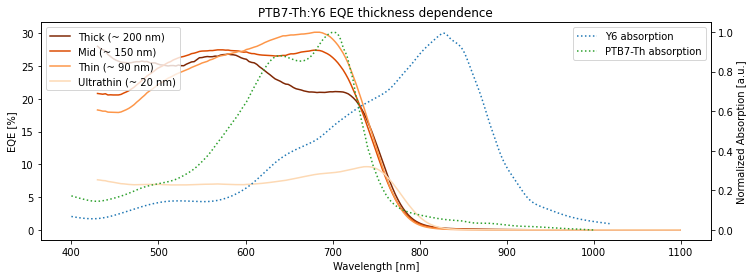

In [4]:
#PTB7-Th:Y6
#Plot EQEs for national plan
#load absorption spectras from references
Y6_absortion = np.loadtxt('Y6absorption.txt')
PTB7Th_absorption = np.loadtxt('PTB7-Thabsorption.txt')
EQEs_to_plot = [0,5, 8, 11]
EQEs_to_plot_names = ['Thick (~ 200 nm)', 'Mid (~ 150 nm)', 'Thin (~ 90 nm)', 'Ultrathin (~ 20 nm)']
colors = plt.cm.Oranges(np.linspace(0.2,1,len(EQEs_to_plot)))
fig, ax = plt.subplots(figsize=(12,4))
for i in range(len(EQEs_to_plot)):
    index = EQEs_to_plot[i]
    ax.plot(RS_EQE_megaarray[10:,0,index], (smooth(RS_EQE_megaarray[:,1,index],15))[10:], color = colors[-i-1], label = EQEs_to_plot_names[i])

ax2 = ax.twinx()

Y6_absoprtion_newx = np.arange(400, max(Y6_absortion[:,0]),1)
ax2.plot(Y6_absoprtion_newx, interpolate.interp1d(Y6_absortion[:,0], Y6_absortion[:,1], kind='cubic')(Y6_absoprtion_newx), label='Y6 absorption', color = 'tab:blue', linestyle = 'dotted')

PTB7Th_absorption_newx = np.arange(400, max(PTB7Th_absorption[:,0]),1)
ax2.plot(PTB7Th_absorption_newx, interpolate.interp1d(PTB7Th_absorption[:,0], PTB7Th_absorption[:,1], kind='cubic')(PTB7Th_absorption_newx), label='PTB7-Th absorption', color = 'tab:green', linestyle = 'dotted')


ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Normalized Absorption [a.u.]')
ax.set_ylabel('EQE [%]')
ax.set_xlabel('Wavelength [nm]')
ax.set_title('PTB7-Th:Y6 EQE thickness dependence')
fig.savefig('PTB7Th_Y6 EQE thickness dependence.png', dpi=300, bbox_inches='tight')

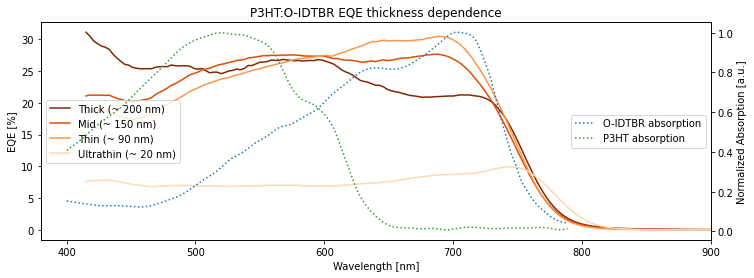

In [7]:
#P3HT:O-IDTBR
#Plot EQEs for national plan
#load absorption spectras from references
OIDTBR_absortion = np.loadtxt('OIDTBRabsorption.txt')
P3HT_absorption = np.loadtxt('P3HTabsorption.txt')
#EQEs_to_plot = [0,5, 7, 10]
EQEs_to_plot = [0,5, 8, 11]
EQEs_to_plot_names = ['Thick (~ 200 nm)', 'Mid (~ 150 nm)', 'Thin (~ 90 nm)', 'Ultrathin (~ 20 nm)']
colors = plt.cm.Oranges(np.linspace(0.2,1,len(EQEs_to_plot)))
fig, ax = plt.subplots(figsize=(12,4))
for i in range(len(EQEs_to_plot)):
    index = EQEs_to_plot[i]
    ax.plot(RS_EQE_megaarray[5:,0,index], (smooth(RS_EQE_megaarray[:,1,index],10))[5:], color = colors[-i-1], label = EQEs_to_plot_names[i])

ax2 = ax.twinx()

absoprtion_newx = np.arange(400, 790,1)
ax2.plot(absoprtion_newx, interpolate.interp1d(OIDTBR_absortion[:,0], OIDTBR_absortion[:,1], kind='cubic')(absoprtion_newx)/max(OIDTBR_absortion[:,1]), label='O-IDTBR absorption', color = 'tab:blue', linestyle = 'dotted')
ax2.plot(absoprtion_newx, interpolate.interp1d(P3HT_absorption[:,0], P3HT_absorption[:,1], kind='cubic')(absoprtion_newx)/max(P3HT_absorption[:,1]), label='P3HT absorption', color = 'tab:green', linestyle = 'dotted')


ax.legend(loc='center left')
ax2.legend(loc='center right')
ax2.set_ylabel('Normalized Absorption [a.u.]')
ax.set_ylabel('EQE [%]')
ax.set_xlim(380,900)
ax.set_xlabel('Wavelength [nm]')
ax.set_title('P3HT:O-IDTBR EQE thickness dependence')
fig.savefig('P3HT_OIDTBR EQE thickness dependence_v2.png', dpi=300, bbox_inches='tight')

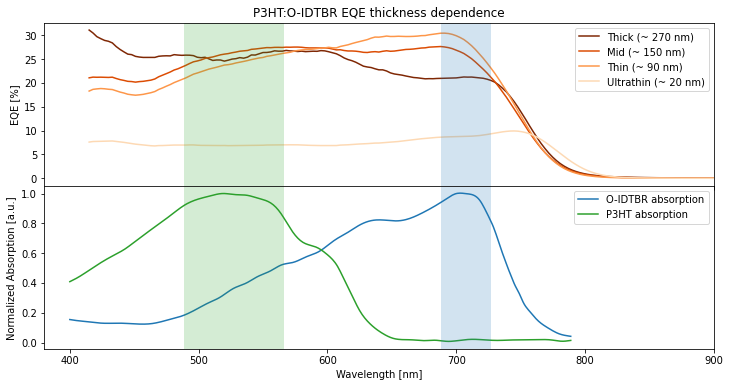

In [42]:
#P3HT:O-IDTBR
#Plot EQEs for national plan
#load absorption spectras from references
OIDTBR_absortion = np.loadtxt('OIDTBRabsorption.txt')
P3HT_absorption = np.loadtxt('P3HTabsorption.txt')
#EQEs_to_plot = [0,5, 7, 10]        #V2
EQEs_to_plot = [0,5, 8, 11]         #V1
EQEs_to_plot_names = ['Thick (~ 270 nm)', 'Mid (~ 150 nm)', 'Thin (~ 90 nm)', 'Ultrathin (~ 20 nm)']
colors = plt.cm.Oranges(np.linspace(0.2,1,len(EQEs_to_plot)))


fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
for i in range(len(EQEs_to_plot)):
    index = EQEs_to_plot[i]
    axs[0].plot(RS_EQE_megaarray[5:,0,index], (smooth(RS_EQE_megaarray[:,1,index],10))[5:], color = colors[-i-1], label = EQEs_to_plot_names[i])


absoprtion_newx = np.arange(400, 790,1)
axs[1].plot(absoprtion_newx, interpolate.interp1d(OIDTBR_absortion[:,0], OIDTBR_absortion[:,1], kind='cubic')(absoprtion_newx)/max(OIDTBR_absortion[:,1]), label='O-IDTBR absorption', color = 'tab:blue')#, linestyle = 'dotted')
axs[1].plot(absoprtion_newx, interpolate.interp1d(P3HT_absorption[:,0], P3HT_absorption[:,1], kind='cubic')(absoprtion_newx)/max(P3HT_absorption[:,1]), label='P3HT absorption', color = 'tab:green')#, linestyle = 'dotted')
axs[0].axvline(x=max(OIDTBR_absortion[:,1]), c='tab:blue', alpha=0.2, linewidth = 80)

axs[0].axvline(x=OIDTBR_absortion[np.argmax(OIDTBR_absortion[:,1])+1,0], c='tab:blue', alpha=0.2, linewidth = 50)
axs[1].axvline(x=OIDTBR_absortion[np.argmax(OIDTBR_absortion[:,1])+1,0], c='tab:blue', alpha=0.2, linewidth = 50)

axs[0].axvline(x=P3HT_absorption[np.argmax(P3HT_absorption[:,1])+1,0], c='tab:green', alpha=0.2, linewidth = 100)
axs[1].axvline(x=P3HT_absorption[np.argmax(P3HT_absorption[:,1])+1,0], c='tab:green', alpha=0.2, linewidth = 100)

fig.subplots_adjust(hspace=0)
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].set_ylabel('Normalized Absorption [a.u.]')
axs[0].set_ylabel('EQE [%]')
axs[0].set_xlim(380,900)
axs[1].set_xlabel('Wavelength [nm]')
axs[0].set_title('P3HT:O-IDTBR EQE thickness dependence')
#fig.savefig('P3HT_OIDTBR EQE thickness dependence_v1.png', dpi=300, bbox_inches='tight')

In [20]:
try:
    BS_cellname
except NameError:
    pass
else:
    BSRS_cellname = BS_cellname

try:
    RS_cellname
except NameError:
    pass
else:
    BSRS_cellname = RS_cellname

def rainbow_data_intplot(Red_sweep, Blue_sweep, cell_name = BSRS_cellname[0]):
    indx = [i for i, s in enumerate(BSRS_cellname) if cell_name in s][0]
    if Red_sweep or Blue_sweep:  #We only initialize the plotting section in case it is needed! (any of Red or Blue sweep is True)
        gs = gridspec.GridSpec(2, 2)        # Create a 2x2 grid for plotting the cell parameters rainbow measurements
        fig = plt.figure(figsize=(10, 6.6666)) #(12,8) proportion
        ax1 = fig.add_subplot(gs[0, 0])     # Efficiency
        ax2 = fig.add_subplot(gs[0, 1])     # FF
        ax3 = fig.add_subplot(gs[1, 0])     # Voc
        ax4 = fig.add_subplot(gs[1, 1])     # Jsc
        ax1.set(xlabel="Dividing Wavelength [nm]", ylabel="Efficiency [%]")
        ax2.set(xlabel="Dividing Wavelength [nm]", ylabel="FF [%]")
        ax3.set(xlabel="Dividing Wavelength [nm]", ylabel="Voc [V]")
        ax4.set(xlabel="Dividing Wavelength [nm]", ylabel="Jsc [A/m^2]")
        fig.suptitle(
            "Rainbow measurements for " + str(cellname),
            fontsize=16,
        )

    if Red_sweep: #If the Red_sweep boolean is true
        try:    #Chech if the RS megaarray exists
            RS_measure_megaarray
        except NameError:   #In case it does not exist, it means that no data is loaded
            print(str(cell_name)+' does not have Red sweep measures loaded!!')  #Print the corresponding error message
        else: # Plot the red sweep data in case the measures are loaded properly
            ax1.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 5, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax2.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 4, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax3.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 3, indx],
                label='Red Sweep',
                color='tab:red',
            )
            ax4.plot(
                RS_measure_megaarray[:, 0, indx],
                RS_measure_megaarray[:, 2, indx],
                label='Red Sweep',
                color='tab:red',
            )
    
    if Blue_sweep:  #In case the Blue_sweep boolean is true
        try:    #Check if the BS megaarray exists
            BS_measure_megaarray
        except NameError:   #In case it des not exist, it means that the measures are not loaded
            print(str(cell_name)+' does not have Blue sweep measures loaded!!')    #Just print the corresponding error message
        else:   #In case it exists, do the regular plot for the blue sweep rainbow measurements                
            ax1.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 5, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax2.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 4, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax3.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 3, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
            ax4.plot(
                BS_measure_megaarray[:, 0, indx],
                BS_measure_megaarray[:, 2, indx],
                label='Blue Sweep',
                color='tab:blue',
            )
    
    if Red_sweep or Blue_sweep: #In case we have initialized the plots, just need to define some more fancy things after all the plotting
        plt.legend()
        plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1)
    
    if not Red_sweep and not Blue_sweep: # In case the Red Blue booleans are both falses, no ploting will be initialized and therefore we need to print a mesage. 
        print('Nothing to plot :(')  

widgets.interact(rainbow_data_intplot, cell_name = BSRS_cellname, Red_sweep = False, Blue_sweep = False)


interactive(children=(Checkbox(value=False, description='Red_sweep'), Checkbox(value=False, description='Blue_…

<function __main__.rainbow_data_intplot(Red_sweep, Blue_sweep, cell_name='L.01')>

# Calculate power difference

## Measuring power vs divwl with thermopile

### Load the thermolipe measurements

In [45]:
calib_folder = 'Power_vs_DivWL_calibrations'


# RS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211028.1Sun210930_divwl.vs.power.calibration.Power_Calibration_Red Sweep Opening.txt'), skiprows=1)
# BS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211028.1Sun210930_divwl.vs.power.calibration.Power_Calibration_Blue Sweep Opening.txt'), skiprows=1)

# RS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118.Power_Calibration_Red Sweep Opening.txt'), skiprows=1)
# BS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118.Power_Calibration_Blue Sweep Opening.txt'), skiprows=1)

# RS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118.Power_Calibration_Red Sweep Closing.txt'), skiprows=1)
# BS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118.Power_Calibration_Blue Sweep Closing.txt'), skiprows=1)

RS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118_m2.Power_Calibration_Red Sweep Opening.txt'), skiprows=1)
BS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118_m2.Power_Calibration_Blue Sweep Opening.txt'), skiprows=1)

# RS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118_m2.Power_Calibration_Red Sweep Closing.txt'), skiprows=1)
# BS_power_divwl = np.loadtxt(os.path.join(calib_folder,'MCV.211118.DivWLpowerCalibration.211118_m2.Power_Calibration_Blue Sweep Closing.txt'), skiprows=1)

### Calculate the EQE

In [18]:
RS_central_wl = [405, 415, 425, 435, 450, 460, 470, 475, 480, 490, 505, 520, 525, 535, 550, 560, 565, 570, 590, 605, 620, 625, 640, 655, 660, 665, 670, 675, 680, 700, 710, 720, 740, 750, 760, 790, 815, 830, 840, 860, 880]

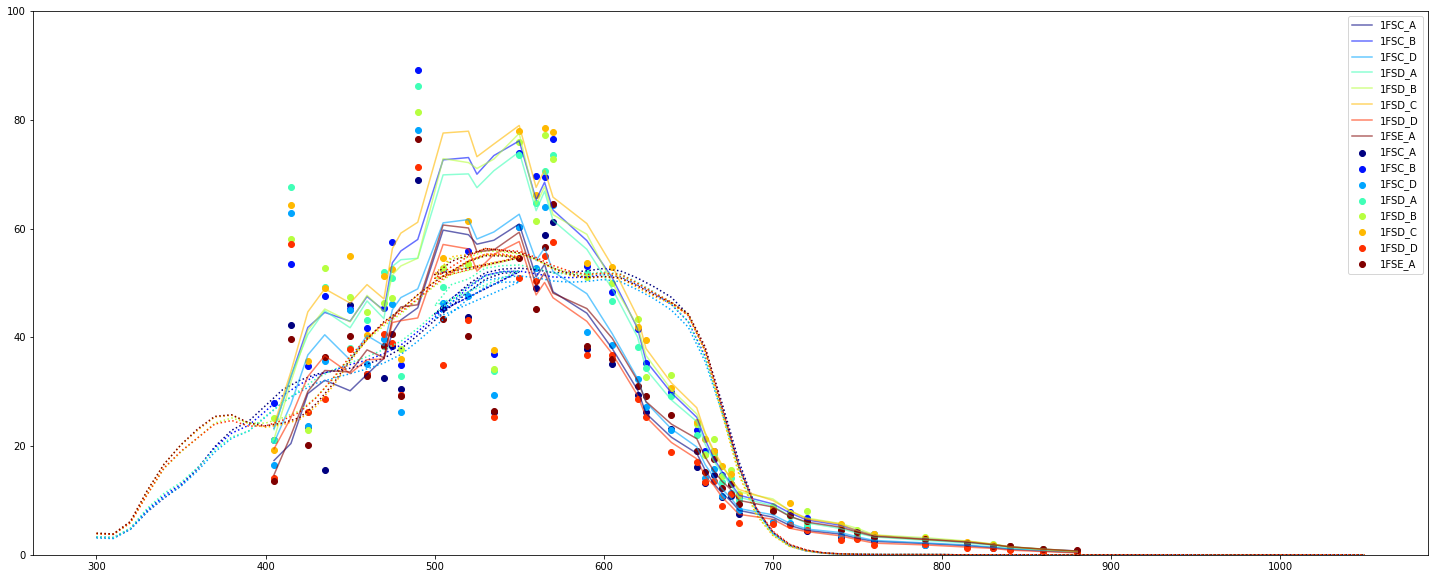

In [46]:
fig, ax = plt.subplots(figsize=(25,10))
colors = plt.cm.jet(np.linspace(0,1,len(RS_EQE_megaarray[0,0,:])))
for i in range(len(RS_EQE_megaarray[0,0,:])):
    for j in range(len(RS_measure_megaarray[:,0,0])-1): # We loop through all the dividing wavelength measured
        actual_wl_min = RS_measure_megaarray[j+1,0,i]
        actual_wl_max = RS_measure_megaarray[j,0,i]
        #actual_wl = (actual_wl_min+actual_wl_max)/2
        actual_wl = RS_central_wl[j]
        actual_power_diff = 1*abs(RS_power_divwl[closest_indx(RS_power_divwl[:,0],actual_wl_max), 2]-RS_power_divwl[closest_indx(RS_power_divwl[:,0], actual_wl_min),2])        
        actual_Jsc_diff = RS_measure_megaarray[j+1,2,i]-RS_measure_megaarray[j,2,i]
        actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
        actual_calculated_EQE = np.array([actual_wl, actual_EQE, actual_power_diff, actual_Jsc_diff])
        try:
            calculated_EQE
        except NameError:
            calculated_EQE = actual_calculated_EQE
        else:
            calculated_EQE = np.vstack((calculated_EQE, actual_calculated_EQE))
    RS_calculated_EQE = calculated_EQE
    del calculated_EQE

    ax.plot(RS_calculated_EQE[:,0], smooth(RS_calculated_EQE[:,1],5), label=RS_cellname[i], color = colors[i], alpha = 0.6)
    ax.scatter(RS_calculated_EQE[:,0], RS_calculated_EQE[:,1], label=RS_cellname[i], color = colors[i])
    ax.plot(RS_EQE_megaarray[:,0,i], RS_EQE_megaarray[:,3,i], color = colors[i], linestyle = 'dotted')
plt.ylim(0,100)
#plt.xlim(400,810)
plt.legend()

C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_6688/2984345325.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_6688/2984345325.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_6688/2984345325.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_6688/2984345325.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
C:\Users\MCASAD~1\AppData\Local\Temp/ipykernel_6688/2984345325.py:11: RuntimeWarning: divide by zero encountered in double_s

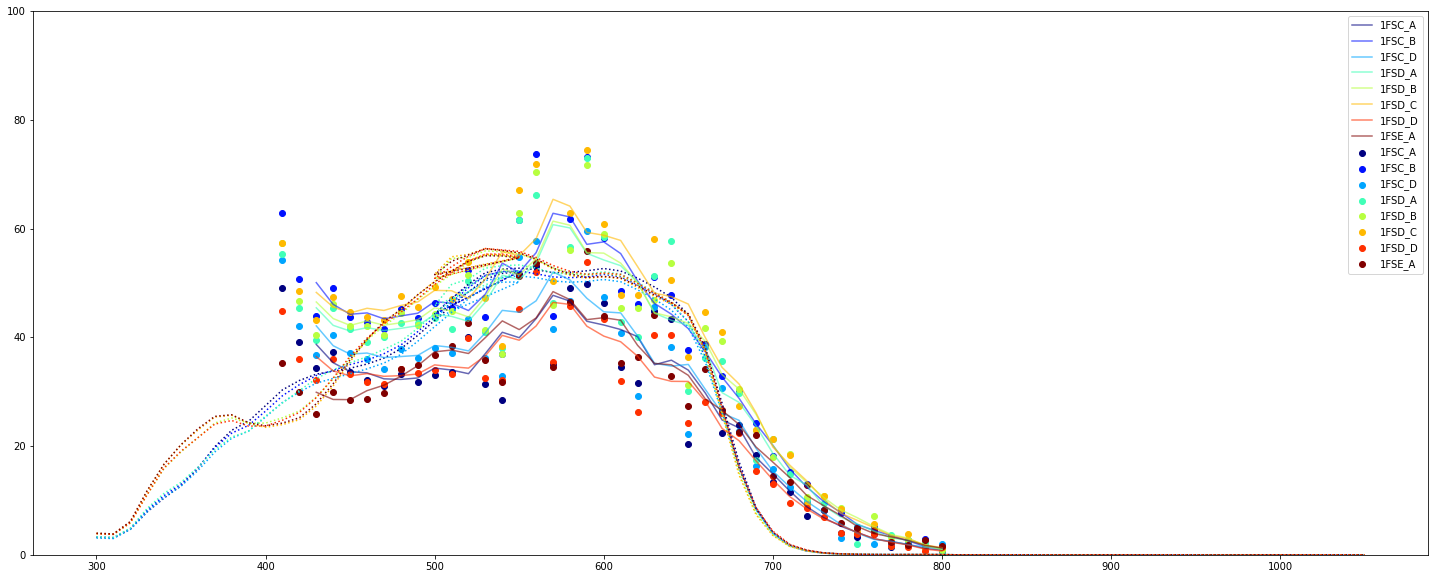

In [44]:
fig, ax = plt.subplots(figsize=(25,10))
colors = plt.cm.jet(np.linspace(0,1,len(BS_EQE_megaarray[0,0,:])))
for i in range(len(BS_EQE_megaarray[0,0,:])):
    for j in range(len(BS_measure_megaarray[:,0,0])-1): # We loop through all the dividing wavelength measured
        actual_wl_min = BS_measure_megaarray[j+1,0,i]
        actual_wl_max = BS_measure_megaarray[j,0,i]
        actual_wl = (actual_wl_min+actual_wl_max)/2
        #actual_wl = RS_central_wl[j]
        actual_power_diff = 1*abs(BS_power_divwl[closest_indx(BS_power_divwl[:,0],actual_wl_max), 2]-BS_power_divwl[closest_indx(BS_power_divwl[:,0], actual_wl_min),2])        
        actual_Jsc_diff = BS_measure_megaarray[j+1,2,i]-BS_measure_megaarray[j,2,i]
        actual_EQE = 100*(actual_Jsc_diff/1.6e-19)/(actual_power_diff*actual_wl/1240/1.6e-19)
        actual_calculated_EQE = np.array([actual_wl, actual_EQE, actual_power_diff, actual_Jsc_diff])
        try:
            calculated_EQE
        except NameError:
            calculated_EQE = actual_calculated_EQE
        else:
            calculated_EQE = np.vstack((calculated_EQE, actual_calculated_EQE))
    BS_calculated_EQE = calculated_EQE
    del calculated_EQE
    ax.plot(BS_calculated_EQE[:,0], -smooth(BS_calculated_EQE[:,1],5), label=BS_cellname[i], color = colors[i], alpha = 0.6)
    ax.scatter(BS_calculated_EQE[:,0], -BS_calculated_EQE[:,1], label=BS_cellname[i], color = colors[i])
    ax.plot(BS_EQE_megaarray[:,0,i], BS_EQE_megaarray[:,3,i], color = colors[i], linestyle = 'dotted')
plt.ylim(0,100)
#plt.xlim(400,810)
plt.legend()